In [1]:
from gensim import corpora, models
import pandas as pd
import os
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Functions

In [2]:
def draw_topics_distribution(topics_results, topic_num):
    ''' take topic distribution and the topic number 
    draws distribution 
    '''
    distrib = pd.DataFrame.from_records(topics_results[topics_results['topic_number']==topic_num]['topic_keywords'].values).T
    distrib =pd.DataFrame.from_records(distrib[0])
    fig, ax = plt.subplots(1,1,figsize =(10,5))
    g1 = sns.barplot(x = distrib.loc[:,0], y = distrib.loc[:,1].astype(float), palette = "mako")
    g1.set(title = 'distribution of words in topic number {}'.format(topic_num),\
         xlabel ='words', ylabel = 'probability of the word' )
    plt.xticks(rotation=90)
    plt.show()
    
    


In [3]:
def get_now_str():
    return datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [4]:

def get_lda_results(data_path, num_topics = 10,num_keywords = 10):
    from gensim import corpora, models
    import os
    import pandas as pd
    """Performs lda keywords extraction for data after lemmatization.

    Parameters
    ----------
    data_path : str
        Path to preprocessed dataset. Dataset must contain a column with name 'tokenized_words_lemmatize'.
    timestamp : str
        Timestamp of getting data
    num_topic : int
        Number of disired topics

    num_keywords : int
        Number of keywords per topic

    Returns
    ------
    result, topic_distribution,lda_model : (DataFrame,DataFrame,model)
        DataFrame with reults, DataFrae with topic distribution and lda_model

    """

    def get_topic_distribution(lda_model, number_of_topics, number_of_keywords):
        topics_distrib = {}
        for t in lda_model.print_topics(number_of_topics,number_of_keywords):
            topics_distrib[t[0]] =[(a.split('*')[1][1:-1],float(a.split("*")[0])) for a in t[1].split(' + ')]
        return topics_distrib


    data = pd.read_csv(data_path)
    columns = ['tokenized_sentences', 'tokenized_words_lemmatize']
    for col in columns:
        data[col] = data[col].apply(eval)

    texts = data.groupby('PMID')['tokenized_words_lemmatize'].agg(lambda x: x.iloc[0]+x.iloc[1])
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    
    lda_model = models.LdaMulticore(corpus=corpus,
                                        id2word=dictionary,
                                        num_topics=num_topics,
                                        passes = 20)
    doc_lda = lda_model[corpus]

    topic_distribution = get_topic_distribution(lda_model,num_topics,num_keywords)
    topics_results = pd.DataFrame.from_records([topic_distribution]).T.reset_index().rename(columns = {'index':'topic_number',0:'topic_keywords'})
    topics_results['keywords'] = topics_results['topic_keywords'].apply(lambda x: [a[0] for a in x])

    

    docs= []
    for doc in doc_lda:
        docs.append({
            'topic_number':doc[0][0],
            'topic_probs': float(doc[0][1]),
            'topic_keywords': topics_results.iloc[doc[0][0]]['topic_keywords'],
            'keywords': topics_results.iloc[doc[0][0]]['keywords']

        })

    docs = pd.DataFrame.from_records(docs)

    results = data[['PMID']].drop_duplicates().reset_index(drop=True).join(docs)
    topics_results = pd.DataFrame.from_records([topic_distribution]).T.reset_index().rename(columns = {'index':'topic_number',0:'topic_keywords'})



    return results,topics_results, lda_model

In [5]:
def get_keywords_lda(data_path, models_path, results_path, timestamp, num_topics = 10,num_keywords = 10):
    """Performs lda keywords extraction for data after lemmatization.

    Parameters
    ----------
    data_path : str
        Path to preprocessed dataset. Dataset must contain a column with name 'tokenized_words_lemmatize'.
    
    models_path : str
        Path to save the model to (folder must exist).

    results_path : str
        Path to save the results to (folder must exist).

    timestamp : str
        Timestamp that will be added to filenames

    num_topic : int
        Number of disired topics
        
    num_keywords : int
        Number of keywords for each topic taken

    Returns
    ------
    (result_path, model_save_name) : tuple
        Frist element is the path to created file with extracted keywrods, second - path to created model.
    """

    results,topics_results, lda_model =  get_lda_results(data_path, num_topics ,num_keywords)

    results_path = os.path.join(os.path.join(results_path, f'lda_results_{timestamp}_keywords_{num_keywords}_topics_{num_topics}.csv'))
    results.to_csv(results_path)

    models_path = os.path.join(models_path,f"lda_model_{timestamp}_keywords_{num_keywords}_topics_{num_topics}")
    lda_model.save(models_path)

    return results_path,models_path

# Getting data

In [6]:
folder = '..//../0.RESULTS/preprocessing/'
data_path = os.path.join(folder,"data_whole.csv")
results_path = '..//../0.RESULTS/lda'
models_path  = os.path.join(results_path,'models')
timestamp = get_now_str()
num_topics = 7
num_keywords = 22

In [7]:
get_keywords_lda(data_path, models_path, results_path, timestamp, num_topics,num_keywords)

('..//../0.RESULTS/lda\\lda_results_2023-01-19_20-01-44_keywords_22_topics_7.csv',
 '..//../0.RESULTS/lda\\models\\lda_model_2023-01-19_20-01-44_keywords_22_topics_7')

# Visualization

In [8]:
results,topics_results, lda_model =get_lda_results(data_path, num_topics,num_keywords)

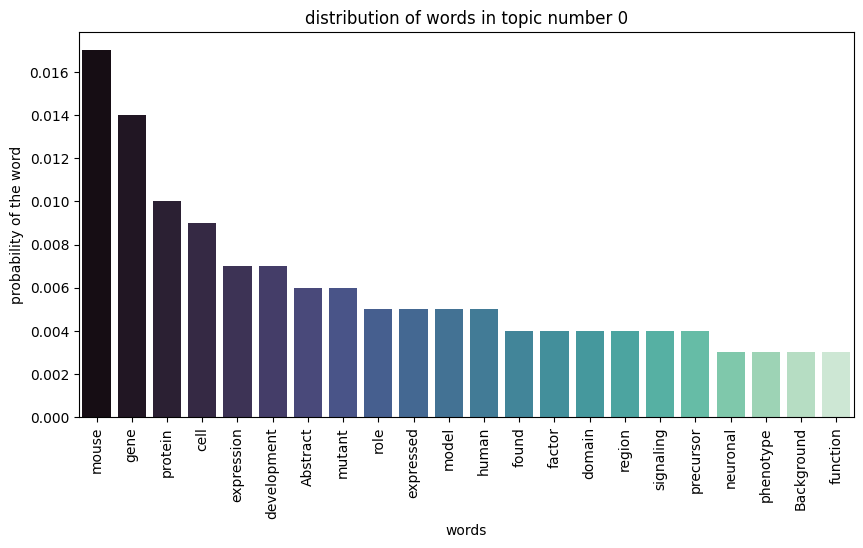

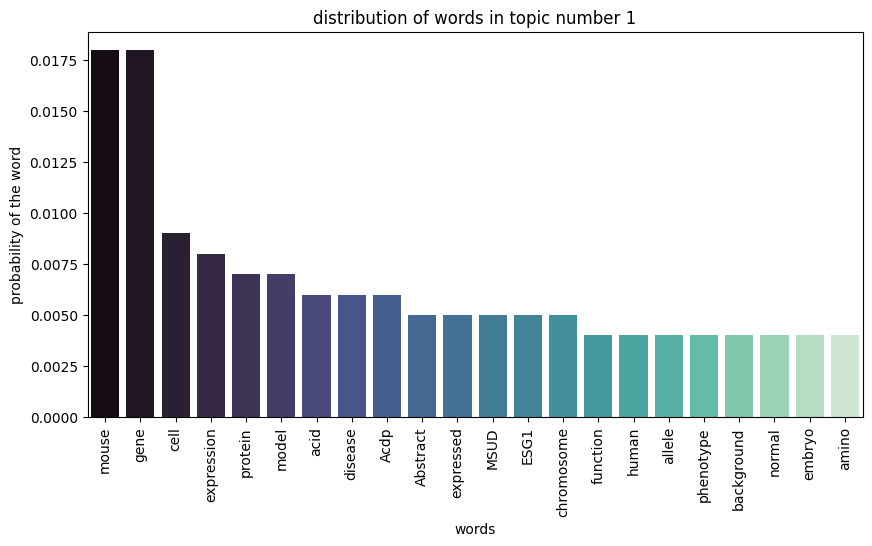

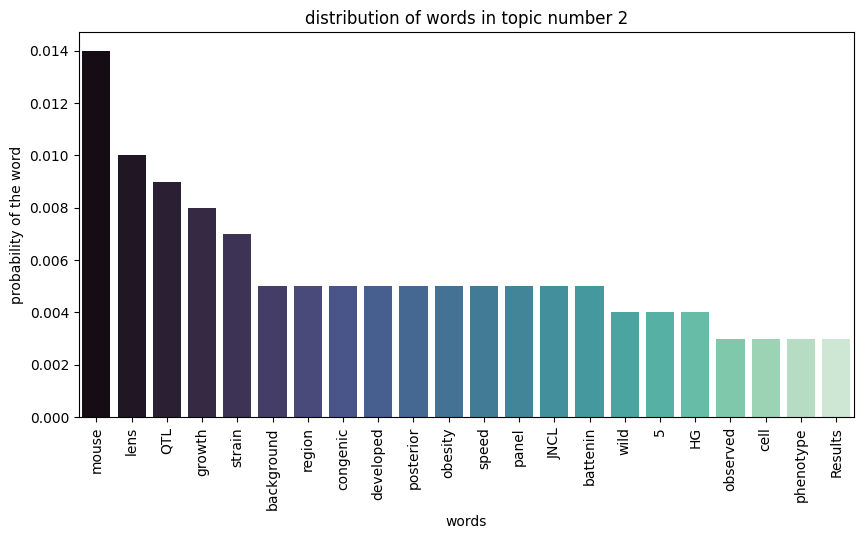

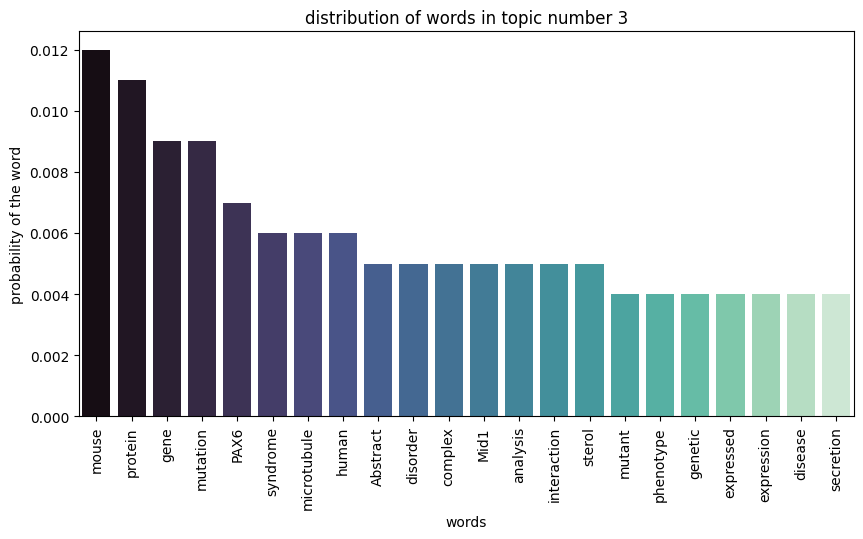

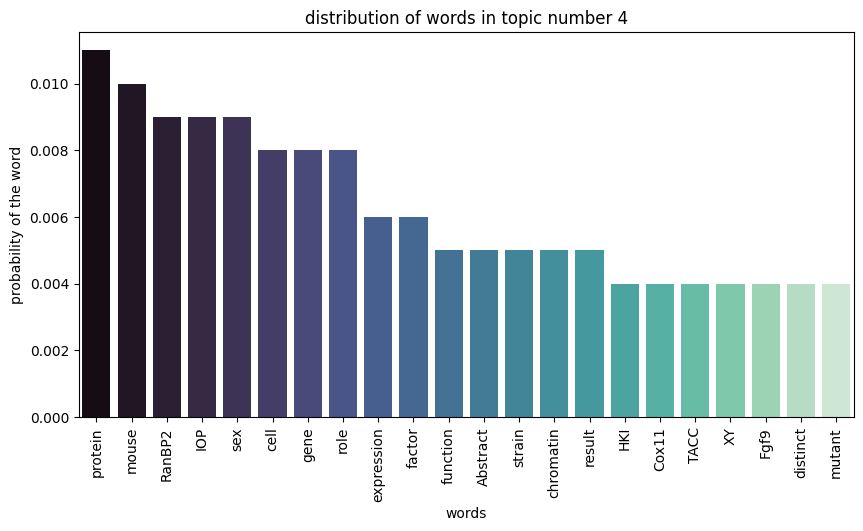

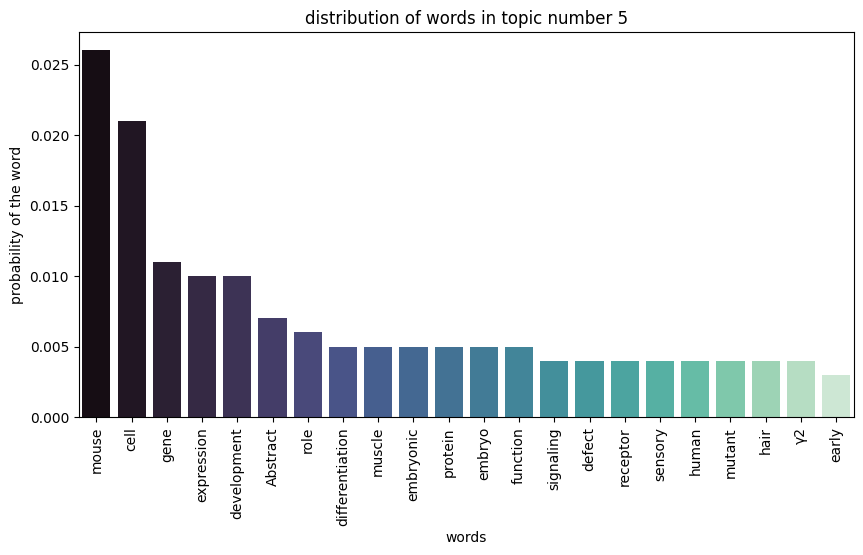

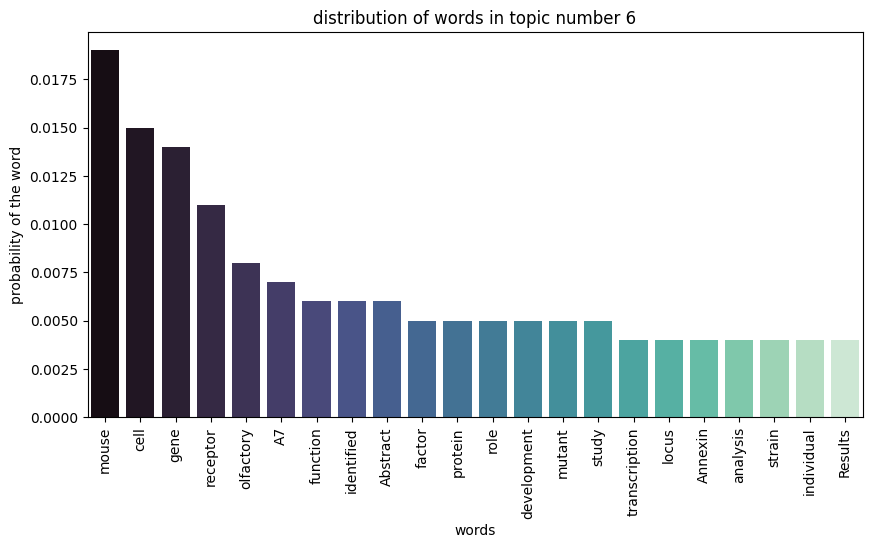

In [9]:
for topic_num in range(num_topics):
    draw_topics_distribution(topics_results, topic_num)